## Comparing solutions to Deterministic, Robust and Stochastic formulations of Unit Commitment (UC) 

This notebook implements some charts that compare the different solution obtained from the three different formulations, over a set of 7 daily instances of UC.

- [Comparing production costs between Robust and Stochastic formulations](#sav)
- [Comparing renewable energy utilization between Robust and Stochastic formulations](#ren)
- [Heatmap comparing solution performance of Robust, Stochastic and Deterministic formulations](#heat)

### Comparing production costs between Robust and Stochastic formulations

<a id=sav ></a>

The following chart reports the daily cost savings (in Euros) that can be obtained by adopting the robust optimization formulation in place of the stochastic formulation. 

Absolute Average Daily Cost Saving: 849.2K Euros
Relative Average Daily Cost Saving: 3.7%


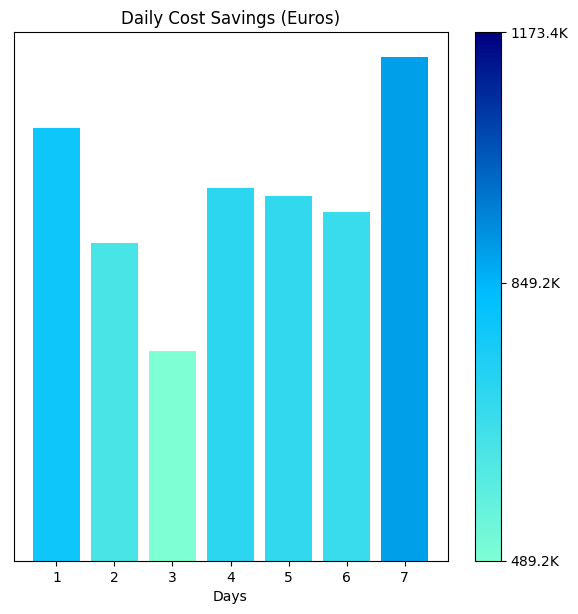

In [1]:
%matplotlib inline
import os, pandas as pd, numpy as np

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm


df_dashboard = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/df_dashboard.csv')

### comparing daily costs between the solutions to robust and stochastic formulations
### the comparison returns the pontetial daily cost saving (it could be negative) if the robust formulation is adopted
do_cost_comp = df_dashboard.copy()[['day', 'model', 'cost']]
do_cost_comp = do_cost_comp.loc[do_cost_comp['model'] != 'D']
do_cost_comp.drop_duplicates(inplace=True)
do_cost_comp_R = do_cost_comp.copy().loc[do_cost_comp['model'] == 'R']
do_cost_comp_R.rename(columns={'cost': 'cost_R'}, inplace=True)
do_cost_comp_R.drop('model', axis=1, inplace=True)
do_cost_comp = do_cost_comp.loc[do_cost_comp['model'] == 'S']
do_cost_comp = do_cost_comp.merge(do_cost_comp_R, on='day', how='inner')
do_cost_comp_X = do_cost_comp.copy()
do_cost_comp['saving'] = do_cost_comp['cost'] - do_cost_comp['cost_R']

do_cost_comp.to_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/df_cost_comp.csv', index=False)

relative_avg_saving = np.mean(do_cost_comp['saving'] / do_cost_comp['cost'])
absolute_avg_saving = do_cost_comp['saving'].mean()

do_cost_comp = do_cost_comp[['day', 'saving']]
do_cost_comp.set_index('day', inplace=True)

### potentail daily savings are displayed with bar chart
fig = plt.figure(figsize=(7, 7), dpi= 100)
cmap = mcolors.LinearSegmentedColormap.from_list("", ["AquaMarine", "DeepSkyBlue", "Navy"])
plt.bar(do_cost_comp.index, do_cost_comp['saving'], color=cmap((do_cost_comp['saving'].values - do_cost_comp['saving'].values.min()) / do_cost_comp['saving'].values.max()))
plt.xticks(do_cost_comp.index, do_cost_comp.index.tolist())
plt.yticks([])
plt.xlabel('Days')
plt.title('Daily Cost Savings (Euros)')
normalize = mcolors.Normalize(vmin=do_cost_comp['saving'].values.min(), vmax=do_cost_comp['saving'].values.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(do_cost_comp['saving'])
legend_ticks = [do_cost_comp['saving'].values.min(), do_cost_comp['saving'].values.mean(), do_cost_comp['saving'].values.max()]
cbar = plt.colorbar(scalarmappaple, ticks=legend_ticks)
cbar.ax.set_yticklabels(["{:.1f}K".format(float(tick) / 1000) for tick in legend_ticks])

print("Absolute Average Daily Cost Saving: {:.1f}K Euros".format(absolute_avg_saving / 1000))
print("Relative Average Daily Cost Saving: {:.1f}%".format(relative_avg_saving * 100))

### Comparing renewable energy utilization between Robust and Stochastic formulations

<a id=ren ></a>

The following chart reports the daily relative gap of the renewable utilization between the robust and the stochastic formulations.

Average Daily Renewable Utilization Gain: 5.1%


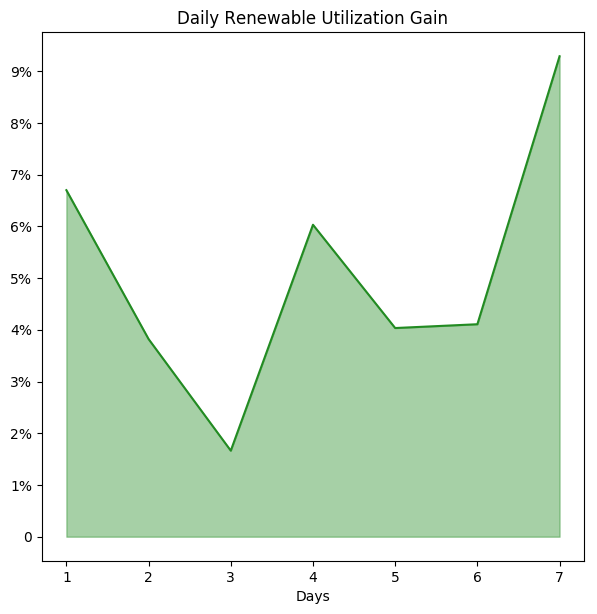

In [2]:
from sklearn import preprocessing

### comparing renewable utilization rate between the solutions to robust and stochastic formulations
### the comparison is based on the ratio between renewable and total energy production (these values are normalized in order to get a relative gap)
### the potential daily gain in renewable utilization (it could be negative) is returned if the robust formulation is adopted
do_ren_comp = df_dashboard.copy()[['day', 'model', 'thermal_prod', 'renewable_prod']]
do_ren_comp = do_ren_comp.loc[do_ren_comp['model'] != 'D']
do_ren_comp = do_ren_comp.groupby(['day', 'model']).sum()
do_ren_comp['ren_rate'] = do_ren_comp['renewable_prod'] / (do_ren_comp['thermal_prod'] + do_ren_comp['renewable_prod'])

x = do_ren_comp[['ren_rate']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
do_ren_comp['ren_rate'] = x_scaled

ref_df = do_ren_comp.copy()
ref_df.reset_index(inplace=True)
ref_df = ref_df[['day', 'model', 'ren_rate']]
ref_df = ref_df.loc[ref_df['model'] == 'R']
ref_df.rename(columns={'ren_rate': 'ref'}, inplace=True)
ref_df.drop('model', axis=1, inplace=True)
do_ren_comp.reset_index(inplace=True)
do_ren_comp = do_ren_comp.merge(ref_df, on='day', how='inner')
do_ren_comp = do_ren_comp.loc[do_ren_comp['model'] == 'S']
do_ren_comp['ren_rate'] = do_ren_comp.apply(lambda x: x.ref - x.ren_rate, axis=1)
do_ren_comp = do_ren_comp[['day', 'ren_rate']]
do_ren_comp.set_index('day', inplace=True)

do_ren_comp.to_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/df_ren_comp.csv')

avg_ren_util_gain = do_ren_comp['ren_rate'].mean()

### potential daily gains in renewable utilization are displayed with a line chart
fig, ax = plt.subplots(figsize=(7, 7), dpi= 100)
ax.plot(do_ren_comp.index, do_ren_comp['ren_rate'], color='ForestGreen')
plt.xticks(do_ren_comp.index, do_ren_comp.index.tolist())
max_y_tick = 1 + int(np.ceil(do_ren_comp['ren_rate'].values.max() * 100))
plt.yticks([float(x) / 100 for x in range(0, max_y_tick)], ["{}%".format(tick) if tick != 0 else 0 for tick in range(0, max_y_tick)])
plt.fill_between(do_ren_comp.index, do_ren_comp['ren_rate'], alpha=0.4, color='ForestGreen')
plt.xlabel('Days')
plt.title('Daily Renewable Utilization Gain')

print("Average Daily Renewable Utilization Gain: {:.1f}%".format(avg_ren_util_gain * 100))

### Heatmap comparing solution performance of Robust, Stochastic and Deterministic formulations

<a id=heat ></a>

The heatmap shows how three models preform in each day, according to the following criteria: the comparison is based on an ex-post analysis that captures the performance of the optimal plan recommended by each model at the beginning of a day, against the actual energy demand registered at the end of the same day.  
The color scale from blue to red illustrates the proximity of planned energy production and system reserve compared to the actual demand. In particular, purple/blue means that the total planned power is very close to the actual demand load registered, and lower and upper reserve levels are suitably centered respect to it. Red/dark red means that the total planned power and related reserve levels turn out to be unbalanced respect to the actual load registered: this requires suitable tactical adjustments to mitigate the deviation from the plan, which lead to higher operational costs at decreased sustainability. From the chart you can see that, for each day of the testbed, the robust formulation provided the best energy production plan against the actual demand, whereas the deterministic formulation’s solution led to the highest deviation.

In [3]:
### we use a heatmap to compare the solution quality of the three formulation
### the kpi used measures the proximity of the recommended plan respect to the actual energy demand registered for each day (the higher value, the higher model performance)
### kpi values have been normalized to achieve the comparison 
df_actual_demand = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/actual_demand.csv')
df_dashboard = df_dashboard.merge(df_actual_demand, on='period', how='inner')
df_dashboard['kpi'] = df_dashboard.apply(lambda x: 0.3 * abs(x.PROD_TOT - x.actual_demand) + \
                                         0.7 * (abs(2 * x.PROD_TOT - x.RES_DOWN_TOT - x.actual_demand) if 2 * x.PROD_TOT - x.RES_DOWN_TOT > x.actual_demand \
                                                    else (abs(2 * x.PROD_TOT + x.RES_UP_TOT - x.actual_demand) if 2 * x.PROD_TOT + x.RES_UP_TOT < x.actual_demand \
                                                          else 0)), axis=1)

df_dashboard = df_dashboard[['model', 'day', 'period', 'Date', 'Hour', 'kpi', 'actual_demand']]
df_kpi = df_dashboard[['model', 'day', 'kpi']].copy()
df_kpi = df_kpi.groupby(['model', 'day']).mean()
df_kpi.reset_index(inplace=True)

x = df_kpi[['kpi']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_kpi['kpi'] = x_scaled
df_kpi['kpi'] = 1 - df_kpi['kpi']

df_kpi.to_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/df_heatmap_comp.csv', index=False)

In [4]:
### the implementation of the heatmap is based on this resource: https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
from mpl_toolkits.axes_grid1 import make_axes_locatable

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax, **cbar_kw)
    #cbar.ax.set_yticklabels(['0', '', '', '',, '', '1'])
    cbar.ax.set_ylabel(cbarlabel, rotation=0, labelpad=2, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


Average Solution Quality Gain: 45.7%


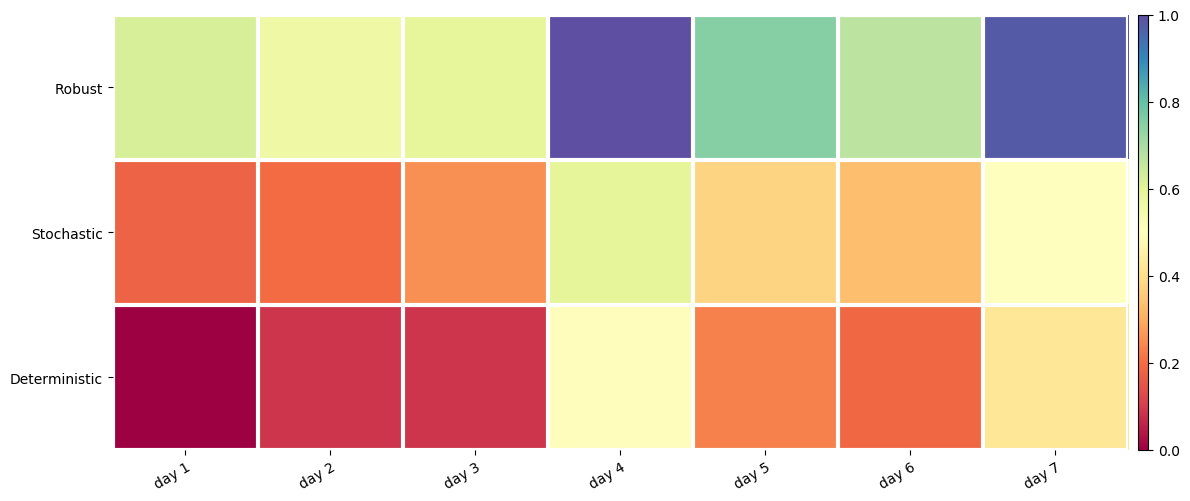

In [5]:
df_heatmap = pd.DataFrame(data={'model':['R', 'S', 'D']})
df_heatmap.set_index('model', inplace=True)
days = df_kpi['day'].unique().tolist()
for day in days:
    for model in df_heatmap.index.values.tolist():
        df_heatmap.at[model, day] = df_kpi.loc[(df_kpi['model'] == model) & (df_kpi['day'] == day), 'kpi'].values[0]
        
fig, ax = plt.subplots(figsize=(12, 12), dpi= 100)
im, cbar = heatmap(df_heatmap.values, ['Robust', 'Stochastic', 'Deterministic'], ["day {}".format(d) for d in df_kpi['day'].values], ax=ax,
                   cmap="Spectral", cbarlabel="")

fig.tight_layout()

avg_sol_quality_gain = np.concatenate((df_heatmap.loc['R'] - df_heatmap.loc['S'], df_heatmap.loc['R'] - df_heatmap.loc['D'])).mean()
print("Average Solution Quality Gain: {:.1f}%".format(avg_sol_quality_gain * 100))

### Author

- __Gianmaria Leo__ is a Senior Operations Research Engineer and Data Scientist with Data Science Elite team (IBM Analytics).

Copyright © IBM Corp. 2018. Released as licensed Sample Materials.